# EDA Raman Spectra

Этот ноутбук выполняет базовый анализ спектров:
- загрузка данных (здоровые / больные),
- сводка по размерам,
- средние спектры,
- PCA визуализация.


In [14]:
# параметры
file_path = "Raman_krov_SSZ-zdorovye.xlsx"  # путь к файлу

In [15]:
import pandas as pd
import numpy as np

df_health = pd.read_excel(file_path, sheet_name="health")
df_disease = pd.read_excel(file_path, sheet_name="heart disease")

wavenumber = df_health["wavenumber"].values
X_health = df_health.drop(columns=["wavenumber"]).T.values
X_disease = df_disease.drop(columns=["wavenumber"]).T.values

print("Healthy shape:", X_health.shape)
print("Disease shape:", X_disease.shape)
print("Wavenumber points:", len(wavenumber))

Healthy shape: (50, 2000)
Disease shape: (50, 2000)
Wavenumber points: 2000


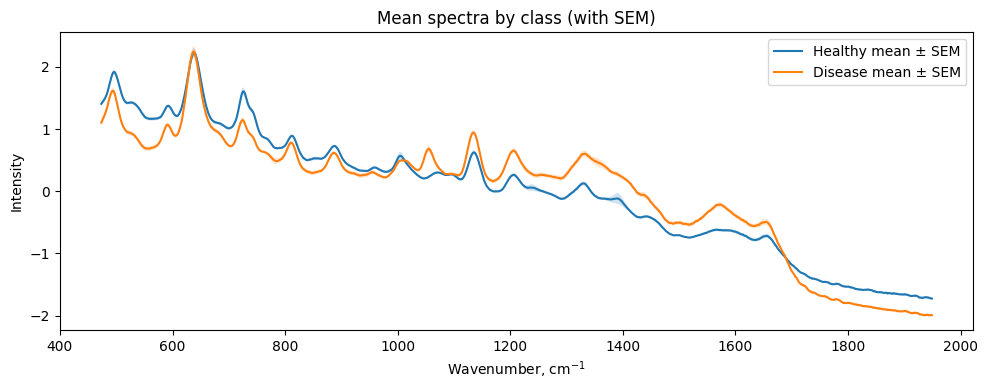

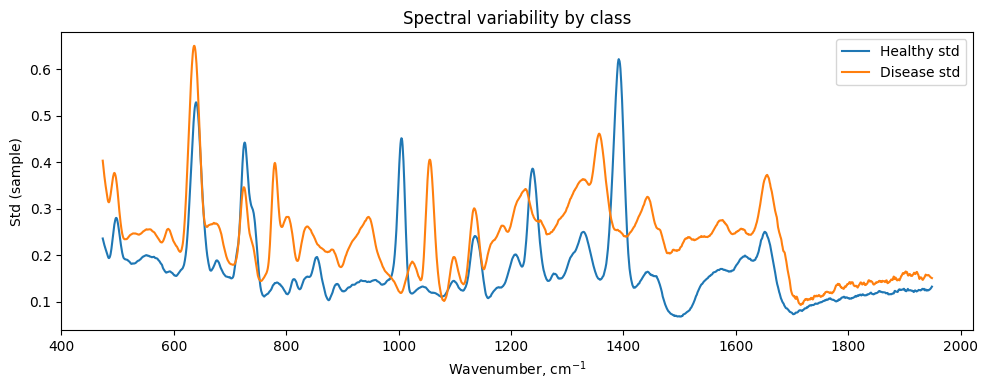

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_with_sem(wavenumber, X, label):
    mean = X.mean(axis=0)
    std  = X.std(axis=0, ddof=1)
    sem  = std / np.sqrt(X.shape[0])
    plt.plot(wavenumber, mean, label=label)
    plt.fill_between(wavenumber, mean-sem, mean+sem, alpha=0.2)

plt.figure(figsize=(10,4))
plot_mean_with_sem(wavenumber, X_health,  "Healthy mean ± SEM")
plot_mean_with_sem(wavenumber, X_disease, "Disease mean ± SEM")
plt.xlabel("Wavenumber, cm$^{-1}$")
plt.ylabel("Intensity")
plt.title("Mean spectra by class (with SEM)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(wavenumber, X_health.std(axis=0, ddof=1),  label="Healthy std")
plt.plot(wavenumber, X_disease.std(axis=0, ddof=1), label="Disease std")
plt.xlabel("Wavenumber, cm$^{-1}$")
plt.ylabel("Std (sample)")
plt.title("Spectral variability by class")
plt.legend()
plt.tight_layout()
plt.show()

Добавим функцию удаления базовой линии

In [17]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def als_baseline(y, lam=1e6, p=0.01, niter=10):
    y = np.asarray(y, dtype=float)
    L = y.size
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * (D @ D.T)
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = np.vstack([X_health, X_disease])

y = np.concatenate([
    np.zeros(X_health.shape[0], dtype=int),
    np.ones(X_disease.shape[0], dtype=int)
])

X_bc = np.empty_like(X, dtype=float)
for i in range(X.shape[0]):
    X_bc[i] = X[i] - als_baseline(X[i], lam=1e6, p=0.01, niter=10)


C:\Users\nastk\AppData\Local\Temp\ipykernel_18624\3977382398.py:12: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  z = spsolve(Z, w * y)


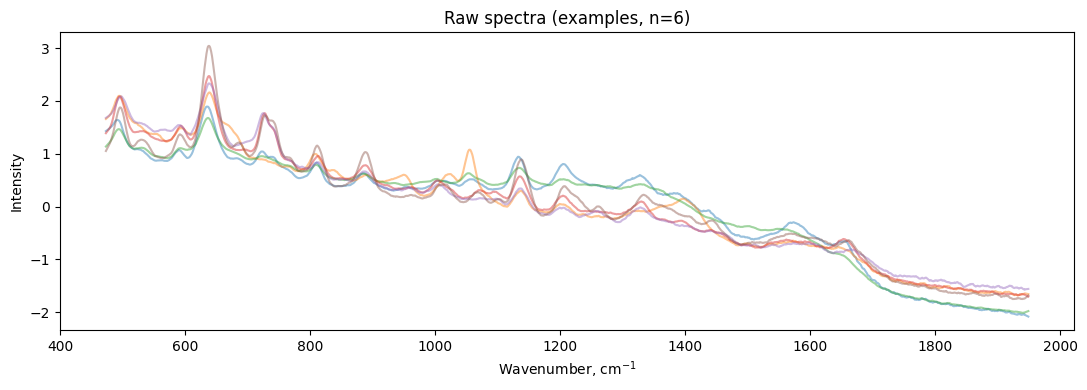

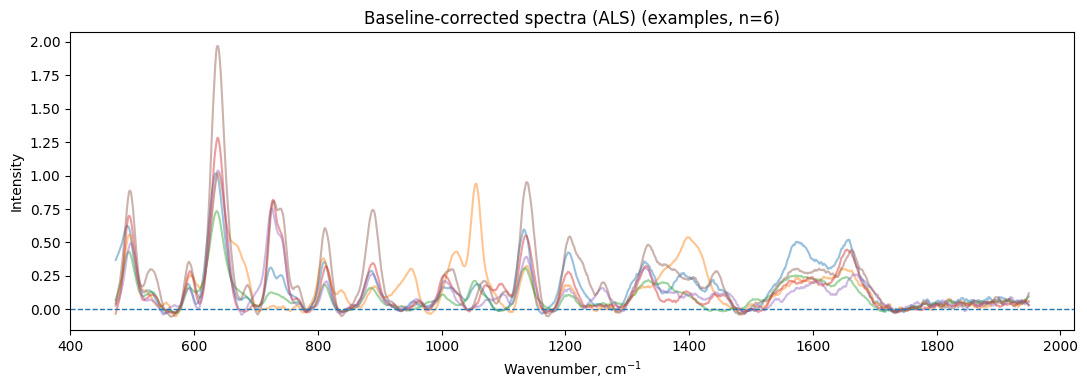

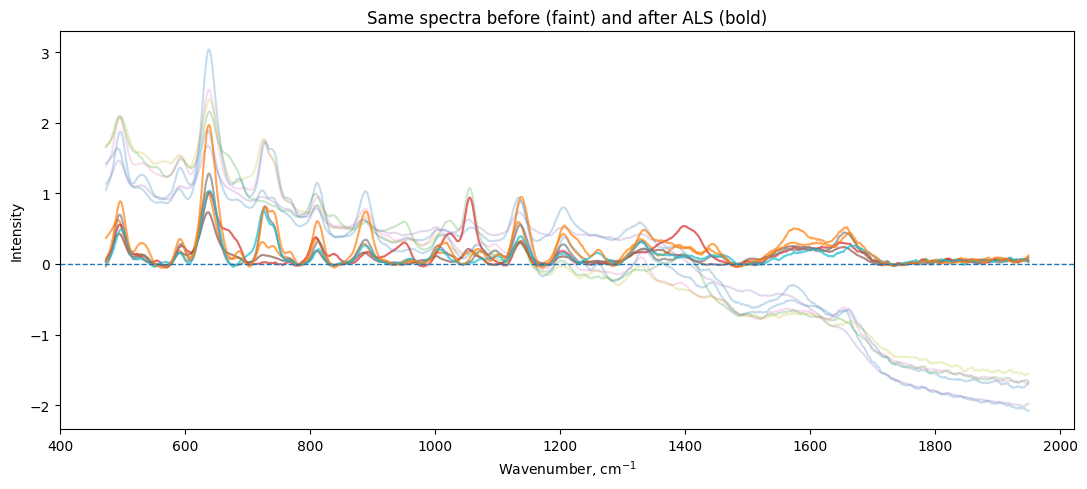

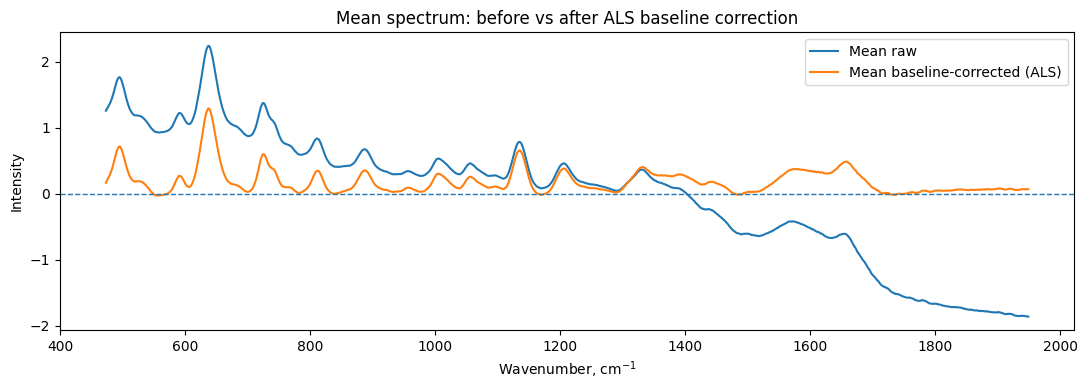

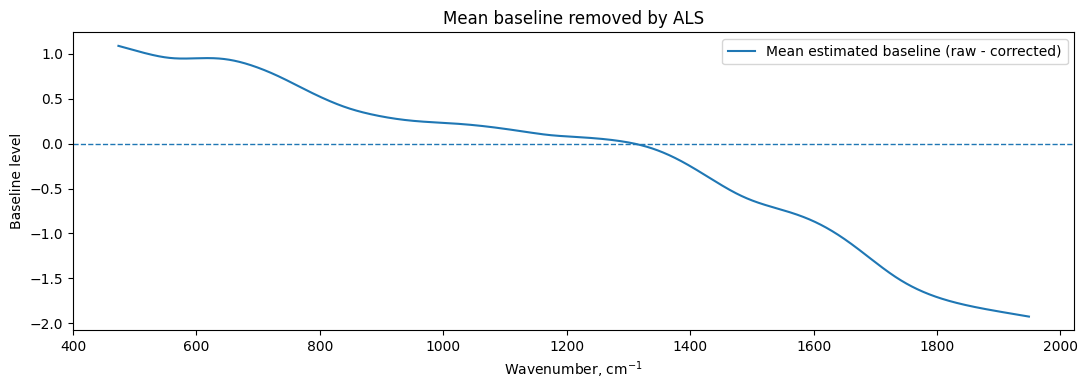

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Несколько случайных спектров до/после ALS ---
np.random.seed(42)
n_show = 6  # сколько спектров показать
idxs = np.random.choice(X.shape[0], size=min(n_show, X.shape[0]), replace=False)

plt.figure(figsize=(11,4))
for idx in idxs:
    plt.plot(wavenumber, X[idx], alpha=0.45)
plt.title(f"Raw spectra (examples, n={len(idxs)})")
plt.xlabel("Wavenumber, cm$^{-1}$"); plt.ylabel("Intensity")
plt.tight_layout()
plt.show()

plt.figure(figsize=(11,4))
for idx in idxs:
    plt.plot(wavenumber, X_bc[idx], alpha=0.45)
plt.title(f"Baseline-corrected spectra (ALS) (examples, n={len(idxs)})")
plt.xlabel("Wavenumber, cm$^{-1}$"); plt.ylabel("Intensity")
plt.axhline(0, linestyle="--", linewidth=1)
plt.tight_layout()
plt.show()

# --- 2) До/после для одного и того же набора спектров (парами) ---
plt.figure(figsize=(11,5))
for idx in idxs:
    plt.plot(wavenumber, X[idx], alpha=0.25)
    plt.plot(wavenumber, X_bc[idx], alpha=0.7)
plt.title("Same spectra before (faint) and after ALS (bold)")
plt.xlabel("Wavenumber, cm$^{-1}$"); plt.ylabel("Intensity")
plt.axhline(0, linestyle="--", linewidth=1)
plt.tight_layout()
plt.show()

# --- 3) Средние спектры до/после + средний baseline ---
mean_raw = X.mean(axis=0)
mean_bc  = X_bc.mean(axis=0)

# средний baseline = mean_raw - mean_bc (то, что в среднем “сняли”)
mean_baseline = mean_raw - mean_bc

plt.figure(figsize=(11,4))
plt.plot(wavenumber, mean_raw, label="Mean raw")
plt.plot(wavenumber, mean_bc, label="Mean baseline-corrected (ALS)")
plt.title("Mean spectrum: before vs after ALS baseline correction")
plt.xlabel("Wavenumber, cm$^{-1}$"); plt.ylabel("Intensity")
plt.axhline(0, linestyle="--", linewidth=1)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(11,4))
plt.plot(wavenumber, mean_baseline, label="Mean estimated baseline (raw - corrected)")
plt.title("Mean baseline removed by ALS")
plt.xlabel("Wavenumber, cm$^{-1}$"); plt.ylabel("Baseline level")
plt.axhline(0, linestyle="--", linewidth=1)
plt.legend()
plt.tight_layout()
plt.show()

 ОТНОШЕНИЕ СИГНАЛ-ШУМ (С/Ш)

In [19]:
def snr_raman(x, wn,
              signal_region=(400, 1700),
              noise_region=(1800, 1950),
              k=6.0,
              baseline_func=None):

    x = np.asarray(x, dtype=float)

    if baseline_func is not None:
        b = baseline_func(x)
        x = x - b

    sig_mask = (wn >= signal_region[0]) & (wn <= signal_region[1])
    noi_mask = (wn >= noise_region[0]) & (wn <= noise_region[1])

    signal = np.max(x[sig_mask])
    sigma = np.std(x[noi_mask], ddof=1)

    return signal / (k * (sigma + 1e-12))


# считаем SNR для всех спектров
snr = np.array([snr_raman(row, wavenumber) for row in X_bc])

# --- Рабочий датасет (без SNR-фильтрации) ---
X_clean = X_snv.copy()          # или X.copy(), если baseline ещё не применял
y_clean = y.copy()
wavenumber_clean = wavenumber.copy()
snr_clean = snr.copy()

In [20]:
def snv(X):
    mean = X.mean(axis=1, keepdims=True)
    std = X.std(axis=1, keepdims=True)
    return (X - mean) / (std + 1e-12)

X_snv = snv(X_bc)

# --- Рабочий датасет (без SNR-фильтрации) ---
X_clean = X_snv.copy()          # или X.copy(), если baseline ещё не применял
y_clean = y.copy()
wavenumber_clean = wavenumber.copy()
snr_clean = snr.copy()

ВИЗУАЛИЗАЦИЯ С/Ш

C:\Users\nastk\AppData\Local\Temp\ipykernel_18624\207757908.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([snr[y==0], snr[y==1]], labels=["Healthy", "Heart disease"], showfliers=True)


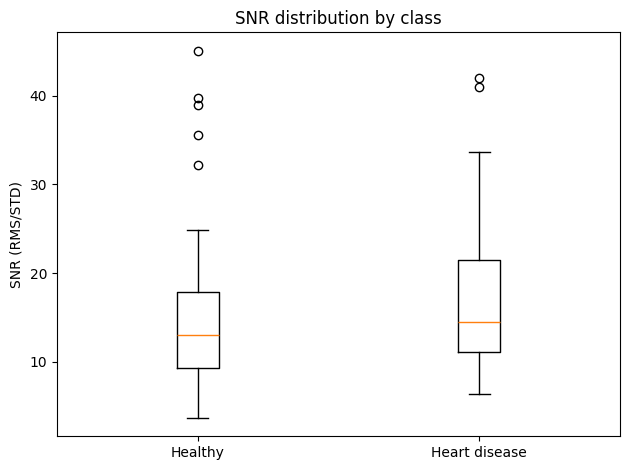

In [21]:
plt.figure()
plt.boxplot([snr[y==0], snr[y==1]], labels=["Healthy", "Heart disease"], showfliers=True)
plt.ylabel("SNR (RMS/STD)")
plt.title("SNR distribution by class")
plt.tight_layout()
plt.show()


проведём тесты на нормальность распределения и статистически значимую разницу в значениях С/Ш между здоровыми и больными пациентами

Healthy  - mean: 15.085143017064217  median: 12.999999459244115
Disease  - mean: 16.767600458760274  median: 14.493356951364664

Shapiro-Wilk p-values: Healthy = 4.129715171565374e-06 , Disease = 0.00011025302406872781

Mann–Whitney U-test: U = 1040.0 , p-value = 0.1486671846875566


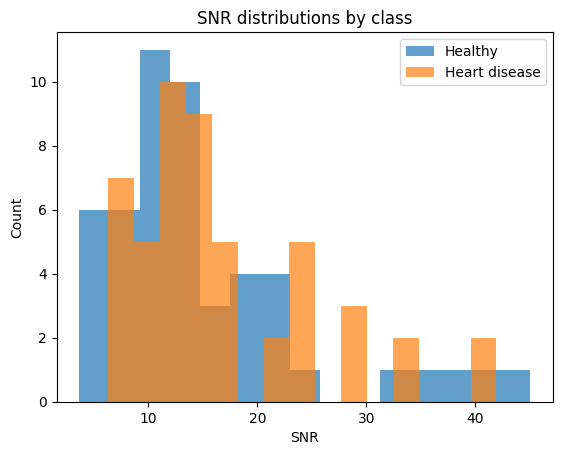

Correlation between SNR and label: 0.09436572931993623


In [22]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Разделяем SNR по классам
snr_healthy = snr[y == 0]
snr_disease = snr[y == 1]

# Быстрая статистика
print("Healthy  - mean:", np.mean(snr_healthy), " median:", np.median(snr_healthy))
print("Disease  - mean:", np.mean(snr_disease), " median:", np.median(snr_disease))

# Тест на нормальность (Shapiro-Wilk)
sh_healthy = stats.shapiro(snr_healthy)
sh_disease = stats.shapiro(snr_disease)
print("\nShapiro-Wilk p-values: Healthy =", sh_healthy.pvalue, ", Disease =", sh_disease.pvalue)

# Тест на равенство распределений (Mann–Whitney U)
u_test = stats.mannwhitneyu(snr_healthy, snr_disease, alternative="two-sided")
print("\nMann–Whitney U-test: U =", u_test.statistic, ", p-value =", u_test.pvalue)

# Визуализация — гистограммы
plt.hist(snr_healthy, bins=15, alpha=0.7, label="Healthy")
plt.hist(snr_disease, bins=15, alpha=0.7, label="Heart disease")
plt.xlabel("SNR"); plt.ylabel("Count")
plt.legend(); plt.title("SNR distributions by class")
plt.show()

print("Correlation between SNR and label:",
      np.corrcoef(snr, y)[0,1])

Анализ показал отсутствие статистически значимой корреляции между уровнем SNR и принадлежностью спектра к классу (r ≈ 0.09). Это свидетельствует о том, что различия между группами обусловлены спектральными особенностями, а не качеством регистрации сигнала.

после фильтрации мы можем видеть на графике отношения С/Ш пороговое ограничение в 15 единиц, что дает нам большее качество данных для обучения модели

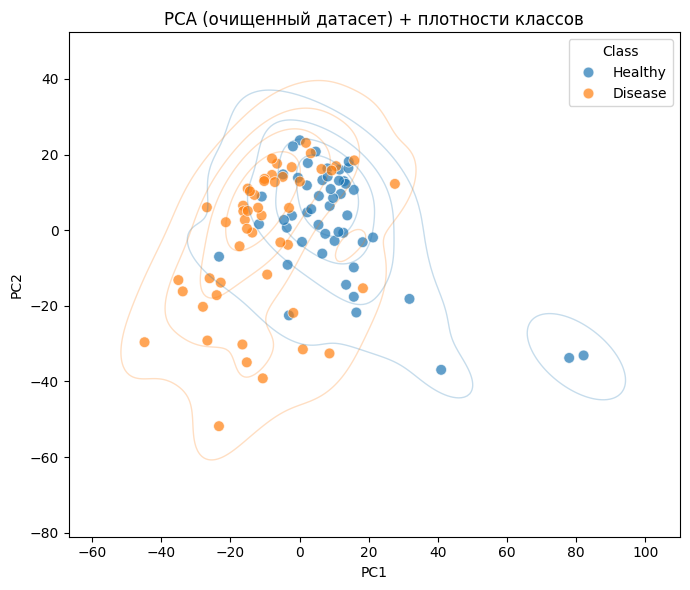

Доля объяснённой дисперсии: [0.17774316 0.14065875] Сумма: 0.3184019102791865


In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Нормализация и PCA для очищенного датасета (только для визуализации)
Xn_clean = StandardScaler().fit_transform(X_clean)

pca_clean = PCA(n_components=2, random_state=42)
Z_clean = pca_clean.fit_transform(Xn_clean)

labels = np.where(y_clean==0, "Healthy", "Disease")

plt.figure(figsize=(7,6))
sns.scatterplot(x=Z_clean[:,0], y=Z_clean[:,1], hue=labels, alpha=0.7, s=60)

# Контуры плотности (исправленные маски)
sns.kdeplot(x=Z_clean[y_clean==0,0], y=Z_clean[y_clean==0,1],
            levels=5, alpha=0.25, linewidths=1)
sns.kdeplot(x=Z_clean[y_clean==1,0], y=Z_clean[y_clean==1,1],
            levels=5, alpha=0.25, linewidths=1)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (очищенный датасет) + плотности классов")
plt.legend(title="Class")
plt.tight_layout()
plt.show()

print("Доля объяснённой дисперсии:", pca_clean.explained_variance_ratio_,
      "Сумма:", pca_clean.explained_variance_ratio_.sum())

Классы частично разделяются вдоль PC1, но сильно перекрываются.
Это значит, что основные линейные различия в спектрах связаны с заболеванием, но они не доминируют над общей вариабельностью

c:\Users\nastk\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


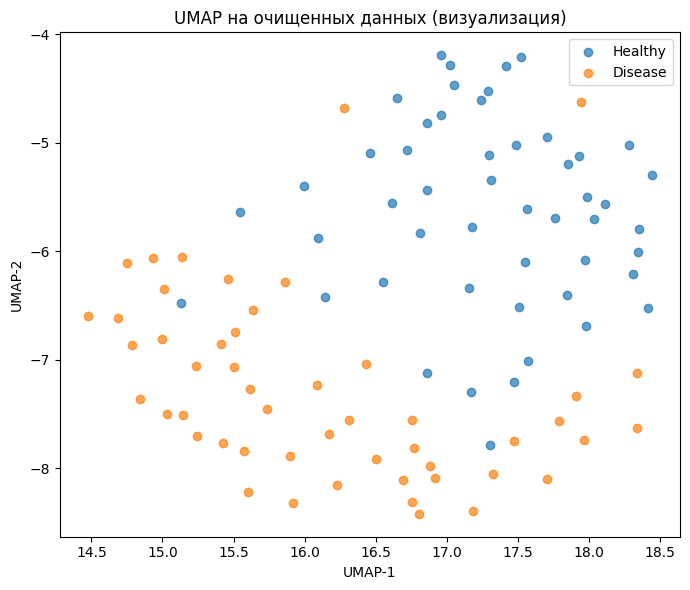

In [24]:
import umap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Xn_umap = StandardScaler().fit_transform(X_clean)

umap_model = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)

Z_umap = umap_model.fit_transform(Xn_umap)

plt.figure(figsize=(7,6))
plt.scatter(Z_umap[y_clean==0,0], Z_umap[y_clean==0,1], label="Healthy", alpha=0.7)
plt.scatter(Z_umap[y_clean==1,0], Z_umap[y_clean==1,1], label="Disease", alpha=0.7)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP на очищенных данных (визуализация)")
plt.legend()
plt.tight_layout()
plt.show()

Проекция спектральных данных в двумерное пространство методом UMAP демонстрирует выраженную кластеризацию наблюдений по классам. Визуально наблюдается разделение групп Healthy и Disease, что подтверждает наличие структурных различий в исходном пространстве признаков

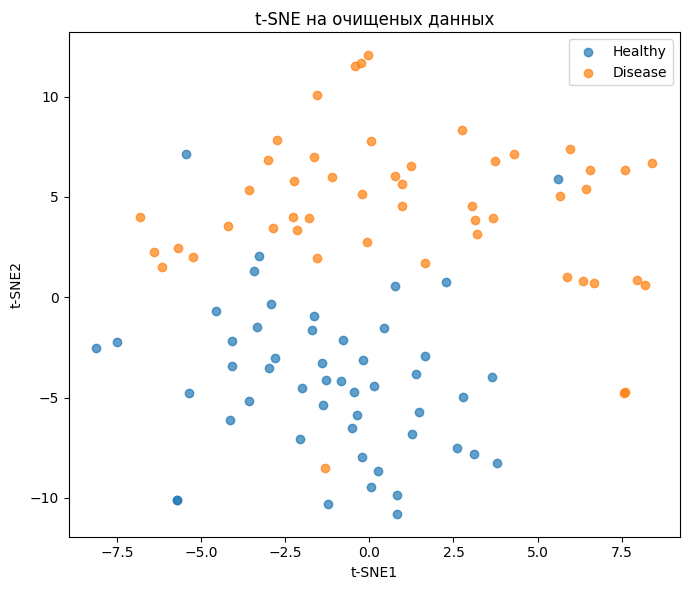

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Нормализация
Xn_tsne = StandardScaler().fit_transform(X_clean)

# t-SNE проекция в 2D
tsne_model = TSNE(n_components=2, perplexity=20, random_state=42, max_iter=1000)
Z_tsne = tsne_model.fit_transform(Xn_tsne)

# Визуализация
plt.figure(figsize=(7,6))
plt.scatter(Z_tsne[y_clean==0,0], Z_tsne[y_clean==0,1], label="Healthy", alpha=0.7)
plt.scatter(Z_tsne[y_clean==1,0], Z_tsne[y_clean==1,1], label="Disease", alpha=0.7)
plt.xlabel("t-SNE1"); plt.ylabel("t-SNE2")
plt.title("t-SNE на очищеных данных")
plt.legend()
plt.tight_layout()
plt.show()



Двумерная визуализация спектральных данных методом t-SNE. Наблюдается кластеризация объектов по классам Healthy и Disease. Метод используется исключительно для визуального анализа структуры данных.

In [26]:
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "roc_auc": "roc_auc",
    "accuracy": "accuracy",
    "f1": "f1",
    "balanced_accuracy": "balanced_accuracy"
}

def report_scores(name, scores):
    print(f"\n{name}")
    for m in scoring.keys():
        vals = scores[f"test_{m}"]
        print(f"  {m:17s}: {vals.mean():.3f} ± {vals.std():.3f}")

models = {
    "LogReg": LogisticRegression(max_iter=5000),
    "SVM (RBF)": SVC(kernel="rbf", probability=True),
    "kNN (k=7)": KNeighborsClassifier(n_neighbors=7),

    "RandomForest": RandomForestClassifier(
        n_estimators=500, random_state=42, n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
}

pipelines = {}

for model_name, clf in models.items():

    # --- Ветка 1: без StandardScaler (актуально, если X_clean уже SNV) ---
    pipelines[f"{model_name} on X (no scaler)"] = Pipeline([
        ("clf", clf)
    ])

    # --- Ветка 2: со StandardScaler (проверка, иногда помогает SVM/kNN) ---
    # Для деревьев скейлер не нужен — пропустим
    if model_name not in ["RandomForest", "GradientBoosting"]:
        pipelines[f"{model_name} on X (scaled)"] = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", clf)
        ])

    # --- PCA(10): имеет смысл в основном для LogReg/SVM/kNN ---
    if model_name in ["LogReg", "SVM (RBF)", "kNN (k=7)"]:
        pipelines[f"{model_name} + PCA(10)"] = Pipeline([
            ("pca", PCA(n_components=10, random_state=42)),
            ("clf", clf)
        ])

        # PCA(10) + scaler (как отдельная проверка)
        pipelines[f"{model_name} + PCA(10) + scaler"] = Pipeline([
            ("pca", PCA(n_components=10, random_state=42)),
            ("scaler", StandardScaler()),
            ("clf", clf)
        ])

for name, pipe in pipelines.items():
    scores = cross_validate(pipe, X_clean, y_clean, cv=cv, scoring=scoring)
    report_scores(name, scores)


LogReg on X (no scaler)
  roc_auc          : 0.992 ± 0.016
  accuracy         : 0.980 ± 0.024
  f1               : 0.980 ± 0.025
  balanced_accuracy: 0.980 ± 0.024

LogReg on X (scaled)
  roc_auc          : 0.994 ± 0.012
  accuracy         : 0.980 ± 0.024
  f1               : 0.980 ± 0.025
  balanced_accuracy: 0.980 ± 0.024

LogReg + PCA(10)
  roc_auc          : 0.968 ± 0.055
  accuracy         : 0.940 ± 0.049
  f1               : 0.938 ± 0.052
  balanced_accuracy: 0.940 ± 0.049

LogReg + PCA(10) + scaler
  roc_auc          : 0.978 ± 0.030
  accuracy         : 0.930 ± 0.051
  f1               : 0.931 ± 0.049
  balanced_accuracy: 0.930 ± 0.051

SVM (RBF) on X (no scaler)
  roc_auc          : 0.982 ± 0.024
  accuracy         : 0.950 ± 0.045
  f1               : 0.952 ± 0.043
  balanced_accuracy: 0.950 ± 0.045

SVM (RBF) on X (scaled)
  roc_auc          : 0.992 ± 0.010
  accuracy         : 0.940 ± 0.037
  f1               : 0.944 ± 0.034
  balanced_accuracy: 0.940 ± 0.037

SVM (RBF) + PC

Проведён сравнительный анализ линейных и нелинейных классификаторов с использованием стратифицированной кросс-валидации. Наилучшие результаты продемонстрировала логистическая регрессия (ROC AUC ≈ 0.98), тогда как нелинейные модели (SVM, ансамблевые методы, kNN) не обеспечили улучшения качества. Это свидетельствует о преимущественно линейной структуре разделимости классов в исходном пространстве спектральных признаков